# Named Entity Recognition with BERT on CoNLL-2003 dataset

## Hyperparameter

In [151]:
task = "ner" # could be one of "ner", "pos" or "chunk"
model_checkpoint = "bert-base-uncased"
batch_size = 16
label_all_tokens = True

# 1. Loading the dataset

In [152]:
# !pip install evaluate
# !pip install seqeval
from datasets import load_dataset
from evaluate import load
import transformers
import numpy as np
import matplotlib.pyplot as plt

print(transformers.__version__)

from transformers import (
    AutoTokenizer, 
    AutoModelForTokenClassification, 
    TrainingArguments, 
    Trainer, 
    DataCollatorForTokenClassification,
    EarlyStoppingCallback
)

4.47.0


In [153]:
datasets = load_dataset("conll2003",trust_remote_code=True)

In [154]:
datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

In [155]:
datasets["train"][0]

{'id': '0',
 'tokens': ['EU',
  'rejects',
  'German',
  'call',
  'to',
  'boycott',
  'British',
  'lamb',
  '.'],
 'pos_tags': [22, 42, 16, 21, 35, 37, 16, 21, 7],
 'chunk_tags': [11, 21, 11, 12, 21, 22, 11, 12, 0],
 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0]}

In [156]:
datasets["train"].features[f"ner_tags"]

Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC'], id=None), length=-1, id=None)

In [157]:
label_list = datasets["train"].features[f"{task}_tags"].feature.names
label_list

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

# 2. Preprocessing the data

In [158]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [159]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples[f"{task}_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                label_ids.append(-100)
            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            else:
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [160]:
tokenize_and_align_labels(datasets['train'][:5])

{'input_ids': [[101, 7327, 19164, 2446, 2655, 2000, 17757, 2329, 12559, 1012, 102], [101, 2848, 13934, 102], [101, 9371, 2727, 1011, 5511, 1011, 2570, 102], [101, 1996, 2647, 3222, 2056, 2006, 9432, 2009, 18335, 2007, 2446, 6040, 2000, 10390, 2000, 18454, 2078, 2329, 12559, 2127, 6529, 5646, 3251, 5506, 11190, 4295, 2064, 2022, 11860, 2000, 8351, 1012, 102], [101, 2762, 1005, 1055, 4387, 2000, 1996, 2647, 2586, 1005, 1055, 15651, 2837, 14121, 1062, 9328, 5804, 2056, 2006, 9317, 10390, 2323, 4965, 8351, 4168, 4017, 2013, 3032, 2060, 2084, 3725, 2127, 1996, 4045, 6040, 2001, 24509, 1012, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 1, 1, 1

In [161]:
tokenized_datasets = datasets.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

# 3. Fine-tuning the model

In [162]:
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(label_list))

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [163]:
model_name = model_checkpoint.split("/")[-1]
args = TrainingArguments(
    f"{model_name}-finetuned-{task}",
    eval_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=10,
    weight_decay=0.01,
    report_to = 'none',
    load_best_model_at_end=True,  
    metric_for_best_model="f1", 
    greater_is_better=True,
)

In [164]:
data_collator = DataCollatorForTokenClassification(tokenizer)

metric = load("seqeval")

labels = [label_list[i] for i in example[f"{task}_tags"]]
metric.compute(predictions=[labels], references=[labels])

{'LOC': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 2},
 'ORG': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 1},
 'PER': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 1},
 'overall_precision': 1.0,
 'overall_recall': 1.0,
 'overall_f1': 1.0,
 'overall_accuracy': 1.0}

In [165]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [166]:
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    # tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# 4. Model Training

In [167]:
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.226700,0.070042,0.900715,0.915427,0.908012,0.979808
2,0.045300,0.059977,0.934423,0.940486,0.937444,0.985067
3,0.025600,0.059535,0.942288,0.942499,0.942394,0.986163
4,0.014400,0.066255,0.931836,0.951225,0.941430,0.985941
5,0.009800,0.073867,0.933598,0.945296,0.939411,0.985194
6,0.005800,0.073269,0.943696,0.948764,0.946223,0.986941
7,0.004900,0.075095,0.936615,0.947198,0.941877,0.985988
8,0.003500,0.077571,0.942594,0.949659,0.946113,0.986798
9,0.002600,0.080450,0.940388,0.949435,0.944890,0.986528


TrainOutput(global_step=7902, training_loss=0.030449928391948287, metrics={'train_runtime': 864.1301, 'train_samples_per_second': 162.487, 'train_steps_per_second': 10.161, 'total_flos': 3066043991202504.0, 'train_loss': 0.030449928391948287, 'epoch': 9.0})

# 5.Model Evaluation

In [168]:
trainer.evaluate()

{'eval_loss': 0.07326921820640564,
 'eval_precision': 0.9436964504283966,
 'eval_recall': 0.9487638438304061,
 'eval_f1': 0.9462233627133773,
 'eval_accuracy': 0.9869413951419448,
 'eval_runtime': 6.7017,
 'eval_samples_per_second': 484.952,
 'eval_steps_per_second': 30.44,
 'epoch': 9.0}

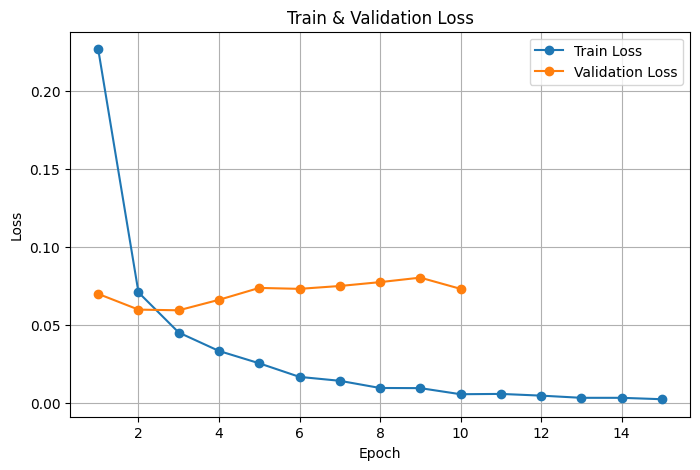

In [169]:
import matplotlib.pyplot as plt


logs = trainer.state.log_history


train_losses = [entry['loss'] for entry in logs if 'loss' in entry]
eval_losses = [entry['eval_loss'] for entry in logs if 'eval_loss' in entry]


epochs_train = list(range(1, len(train_losses) + 1))
epochs_eval = list(range(1, len(eval_losses) + 1))

plt.figure(figsize=(8,5))
plt.plot(epochs_train, train_losses, label="Train Loss", marker="o")
plt.plot(epochs_eval, eval_losses, label="Validation Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Train & Validation Loss")
plt.grid()
plt.show()

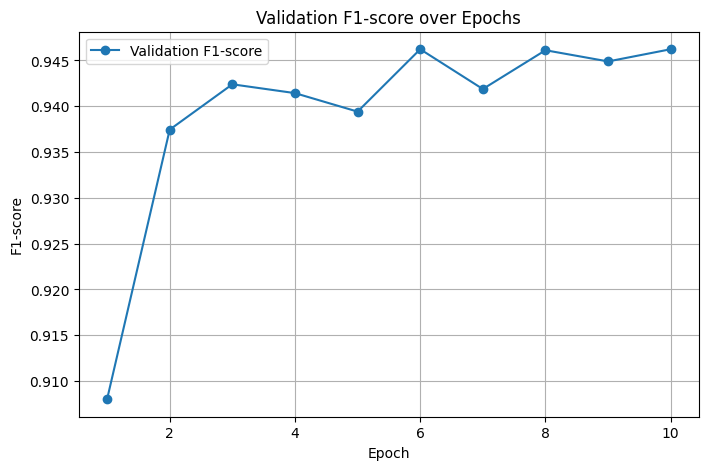

In [170]:
f1_scores = [entry['eval_f1'] for entry in logs if 'eval_f1' in entry]

plt.figure(figsize=(8,5))
plt.plot(range(1, len(f1_scores) + 1), f1_scores, label="Validation F1-score", marker="o")
plt.xlabel("Epoch")
plt.ylabel("F1-score")
plt.legend()
plt.title("Validation F1-score over Epochs")
plt.grid()
plt.show()


In [171]:
test_results = trainer.evaluate(tokenized_datasets["test"])
print(test_results)


{'eval_loss': 0.1748828887939453, 'eval_precision': 0.8956388133790332, 'eval_recall': 0.8993591265131735, 'eval_f1': 0.8974951145851838, 'eval_accuracy': 0.9758994544575651, 'eval_runtime': 6.5073, 'eval_samples_per_second': 530.631, 'eval_steps_per_second': 33.193, 'epoch': 9.0}


In [172]:
predictions, labels, _ = trainer.predict(tokenized_datasets["validation"])
predictions = np.argmax(predictions, axis=2)

# Remove ignored index (special tokens)
true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

results = metric.compute(predictions=true_predictions, references=true_labels)
print('Validation set:')
results

Validation set:


{'LOC': {'precision': 0.962457337883959,
  'recall': 0.9694423223834988,
  'f1': 0.9659372026641293,
  'number': 2618},
 'MISC': {'precision': 0.8753096614368291,
  'recall': 0.8610885458976442,
  'f1': 0.8681408681408681,
  'number': 1231},
 'ORG': {'precision': 0.9139990444338271,
  'recall': 0.9304474708171206,
  'f1': 0.9221499156423234,
  'number': 2056},
 'PER': {'precision': 0.9750492449113591,
  'recall': 0.978905735003296,
  'f1': 0.9769736842105263,
  'number': 3034},
 'overall_precision': 0.9436964504283966,
 'overall_recall': 0.9487638438304061,
 'overall_f1': 0.9462233627133773,
 'overall_accuracy': 0.9869413951419448}

In [173]:
predictions, labels, _ = trainer.predict(tokenized_datasets["test"])
predictions = np.argmax(predictions, axis=2)

# Remove ignored index (special tokens)
true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

results = metric.compute(predictions=true_predictions, references=true_labels)
print('Test set:')
results

Test set:


{'LOC': {'precision': 0.8997711670480549,
  'recall': 0.9256120527306968,
  'f1': 0.9125087027152472,
  'number': 2124},
 'MISC': {'precision': 0.7733050847457628,
  'recall': 0.7329317269076305,
  'f1': 0.752577319587629,
  'number': 996},
 'ORG': {'precision': 0.856396866840731,
  'recall': 0.8871715610510046,
  'f1': 0.8715126209907003,
  'number': 2588},
 'PER': {'precision': 0.975480950584685,
  'recall': 0.9514348785871964,
  'f1': 0.9633078785621157,
  'number': 2718},
 'overall_precision': 0.8956388133790332,
 'overall_recall': 0.8993591265131735,
 'overall_f1': 0.8974951145851838,
 'overall_accuracy': 0.9758994544575651}